# Scripts to plot all best-fit solutions in the paper

In [6]:
# basics
import pandas as pd
import numpy as np

# astronomical units and constants
import astropy.units as u
from astropy.constants import R_sun


# matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib.container import ErrorbarContainer
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# data management
import os
CWD = "/".join(os.getcwd().split("/")[:-2])


# modulation model
from funcs.model import full_model, full_model_coupled, aflare_decoupled, aflare
from funcs.helper import fetch_lightcurve


# Single flare solution decoupled

In [7]:
# Datasets we analysed, and some tinkering with plotting ranges
datasets = [
            (452922110, "normal_uncertainty", None, None,
             "07_12_2020_15_44", ""),
            (452922110,"high_uncertainties_peak1", None, None,
             "10_12_2020_07_05", ""),
            (44984200, "normal_uncertainty", 1587.8,1588.7, 
             "07_12_2020_18_46", ""),
            (44984200, "high_uncertainties_peak1", 1587.8,1588.7,
             "10_12_2020_07_12", "c"), 
            (277539431, "normal_uncertainty", None, None, 
             "07_12_2020_15_26", "")
            ]

7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:190: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/MalachiteMountains/data/lcs/452922110_07_tess_slc_generic.fits' mode='rb' closefd=True>
  return _from_path_LC(path, mission, **kwargs)
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:190: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/MalachiteMountains/data/lcs/452922110_07_tess_slc_generi

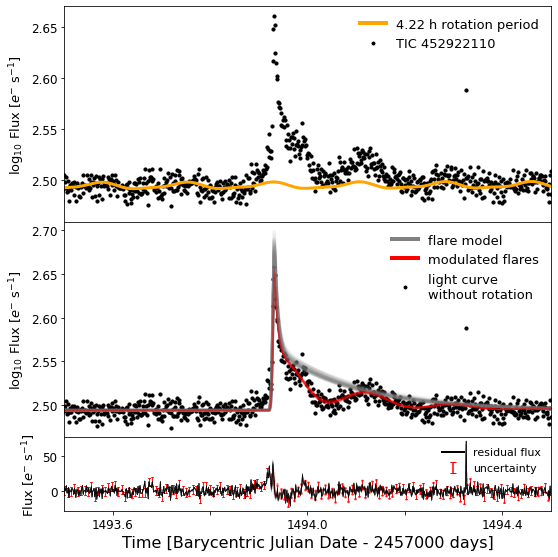

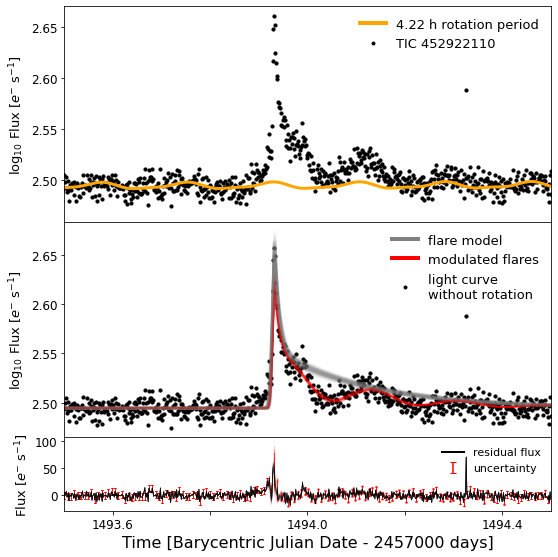

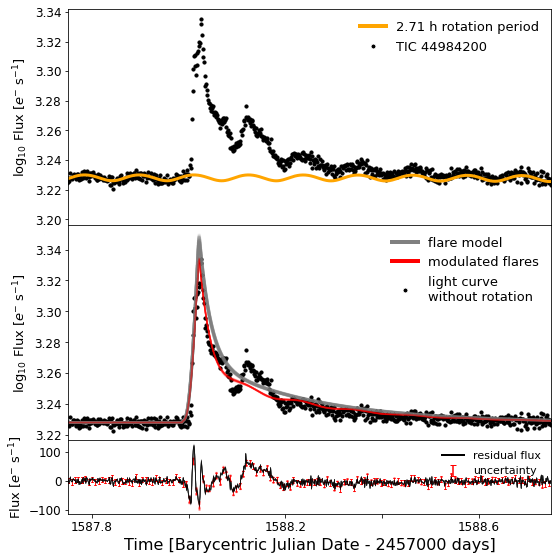

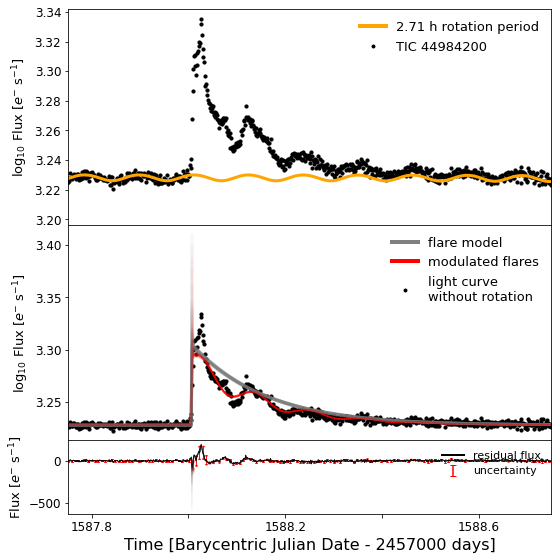

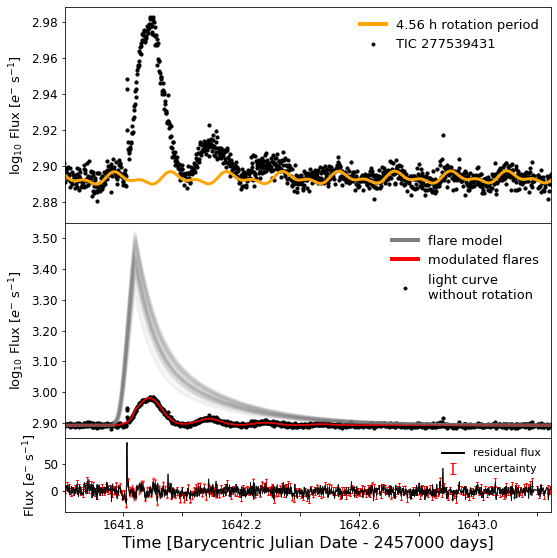

In [8]:
# Pick up stellar parameters
props = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
# Pick up the input parameters
mcmcinit = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
# number of samples from the posterior distribution
N = 50

for ID, name, start, stop, tstamp, suffix in datasets:

    # Get MCMC data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")

    # pick stellar parameters
    target = props[props.ID == int(ID)].iloc[0]
    
    
    inits = mcmcinit[(mcmcinit.ID.astype(str) == str(ID) + suffix) & (mcmcinit.tstamp==tstamp)].iloc[0]
    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg / u.cm**2 / u.s
    R = inits.R_Rsun * R_sun

    # pick up light curve
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    median = lc.median_[0]
    
    # figures geometry: three panel of different size
    # from top to bottom: 
    # TOP: light curve and quiescent flux, rotation period
    # CENTER: flare-only light curve, model solution, underlying flare
    # BOTTOM: flare-model residuals, and uncertainties on flux
    
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    # CENTER: flare-only light curve
    ax.scatter(time, np.log10(flux), s=10, c="k")
    
    # plot N random solutions from the posterior distribution
    inds = np.random.randint(df.shape[0], size=N)
    for ind in inds:
        
        # pick solution from MCMC chain
        sample = df.loc[ind,]
        
        # get flare parameters
        a = sample.a
        phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
        theta_a = sample.latitude_deg / 180 * np.pi
        fwhm1 = sample.fwhm1_d / target.Prot_d * 2 * np.pi
        fwhm2 = sample.fwhm2_d / target.Prot_d * 2 * np.pi
        
        # ... and also the updated inclination
        i = sample.i_deg / 180 * np.pi
        
        # convert flare peak phase to phase at t0
        phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
        
        # CENTER: plot the underlying best-fit flare
        flare = aflare_decoupled(phi, phi_a, (fwhm1,fwhm2), a*median)+ median
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        
        # CENTER: plot the modulated best-fit flare
        fullmodel = full_model(phi_a, theta_a, a, fwhm1, fwhm2, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(fullmodel) , c="r", alpha=0.05)
        
        # BOTTOM: plot the residuals
        ax2.errorbar(time, flux - fullmodel, yerr=lc.flux_err,
                     errorevery=5, c="k", alpha=.05, ecolor="r", 
                     capsize=1, linewidth=.75)
 

    # Fetch the full original light curve
    flck = fetch_lightcurve(target)

    # TOP: plot un-detrended light curve 
    ax3.scatter(flck.time, np.log10(flck.flux), c="k", s=10)
    
    # TOP: plot quiescent flux model
    ax3.plot(lc.t, np.log10(lc.modelflux), linewidth=3, c="orange")    
    
    # TOP LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    

    legend_elements3 = [Line2D([0], [0], color='orange', lw=4, 
                              label=f"{target.Prot_d*24.:.2f} h rotation period"),
                       Line2D([0], [0], marker='o', color='w', 
                              label=f"TIC {ID}",
                              markerfacecolor='k', markersize=5),]
    
    ax3.legend(handles=legend_elements3, fontsize=13, frameon=False, loc=1)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)
        
    #------------------------------------------------------------------------------------------
    
    # BOTTOM LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    
    line = Line2D([],[], ls="none", c="r")
    barline = LineCollection(np.empty((2,2,2)), colors="r")
    err = ErrorbarContainer((line, [line], [barline]), has_yerr=True, label="uncertainty")
    legend_elements2 = [
                       Line2D([0], [0], color='k', lw=2, label="residual flux"),
                       err,
                      ]
    ax2.legend(handles=legend_elements2, fontsize=11, frameon=False, loc=1)
    ax2.set_xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    
    #------------------------------------------------------------------------------------------

    
    # CENTER LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                   Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                   Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                          markerfacecolor='k', markersize=5),]

    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    
    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    #------------------------------------------------------------------------------------------
        
        
    # Y-Labels
    # ------------------------------------------------------------------------    

    ax.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax2.set_ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ------------------------------------------------------------------------    

    
    # remaining layout
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        
    plt.tight_layout()
    
    # Save to file
    
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/"
#                 f"{tstamp}_{target.prefix}{target.ID}_decoupled_{name}.png",
#                 dpi=300)

# Double-flare solution decoupled

In [9]:
# Datasets we analysed
 datasets = [
            (237880881,"normal_uncertainties",
             1331.6,1332.6, 
            "07_12_2020_07_47",),
            (237880881,"high_uncertainties_peaks12",
             1331.6,1332.6,
             "10_12_2020_07_11"),
            (44984200, "normal_uncertainties",  
            1587.8,1588.7, 
            "07_12_2020_19_42"),
            (44984200,"high_uncertainties_peaks12",
               1587.8,1588.8,
              "10_12_2020_07_10")
            ]

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:190: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/MalachiteMountains/data/lcs/237880881_01_tess_slc_generic.fits' mode='rb' closefd=True>
  return _from_path_LC(path, mission, **kwargs)
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:190: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/MalachiteMountains/data/lcs/237880881_01_tess_slc_ge

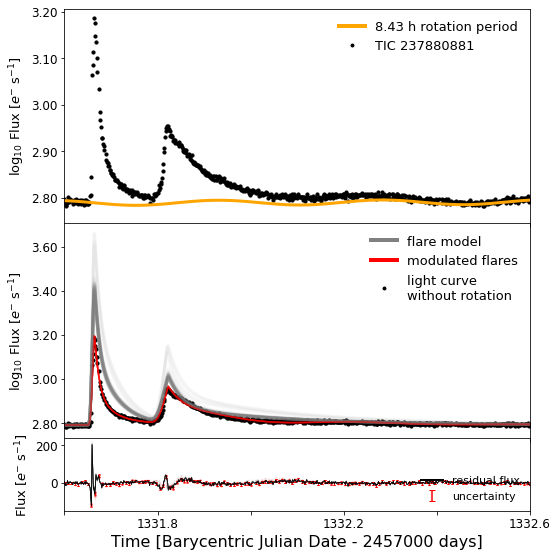

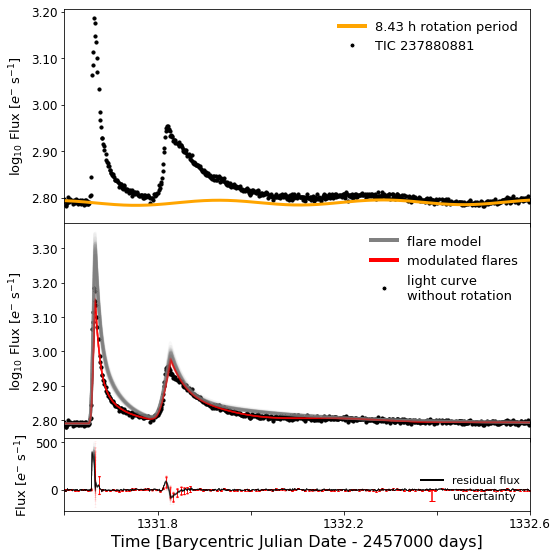

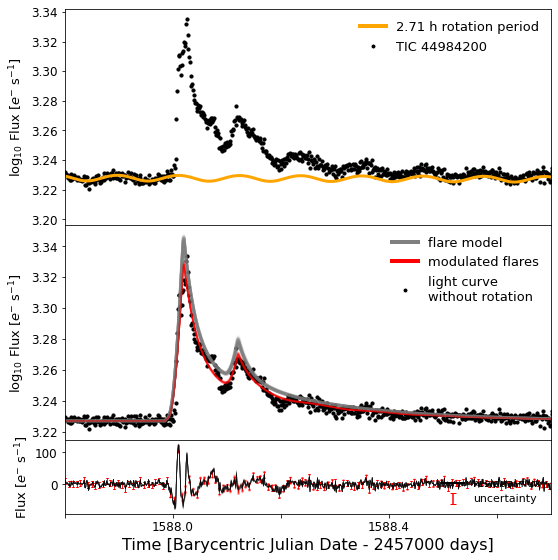

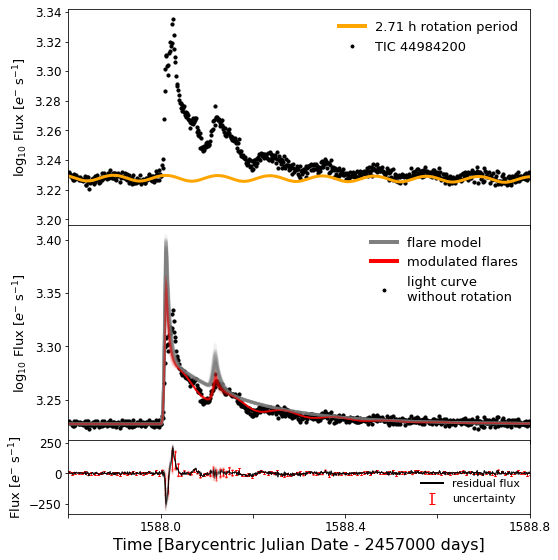

In [10]:
# Pick up stellar parameters
props = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
# Pick up the input parameters
mcmcinit = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
# number of samples from the posterior distribution
N = 50

for ID, name, start, stop, tstamp in datasets:

    # pick up light curve
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    median = lc.median_[0]
    
    # pick up stellar parameters
    target = props[props.ID == int(ID)].iloc[0]

    # get MCMC chain
    #--------------------------------------------------------------
    dfa = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}a_converted_mcmc_sample.csv").reset_index()
    dfb = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}b_converted_mcmc_sample.csv").reset_index()

    # map suffix to chain
    ddic = {"a":dfa, "b":dfb}
    
    # figures geometry: three panels of different size
    #--------------------------------------------------------------

    # from top to bottom: 
    # TOP: light curve and quiescent flux, rotation period
    # CENTER: flare-only light curve, model solution, underlying flare
    # BOTTOM: flare-model residuals, and uncertainties on flux
    
    fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    # CENTER: flare-only light curve
    ax.scatter(time, np.log10(flux), s=10, c="k")
    
    #--------------------------------------------------------------
 
    # plot a number of random solutions from the posterior distribution
    inds = np.random.randint(dfa.shape[0], size=N)
    for ind in inds:
        
        # start with the median and add both flares on top
        flare = np.full(len(phi), median,)
        fullmodel = np.full(len(phi), median)
        
        # do one flare at a time
        for suffix in ["a","b"]:
            
            # get stellar parameters
            inits_ = mcmcinit[(mcmcinit.ID == str(ID)+suffix) & (mcmcinit.tstamp==tstamp)].iloc[0]
            qlum = inits_.qlum_erg_s * u.erg / u.s
            Fth = inits_.Fth * u.erg / u.cm**2 / u.s
            R = inits_.R_Rsun * R_sun

            # get flare parameters
            df = ddic[suffix]
            sample = df.loc[ind,]
            a = sample.a
            phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
            theta_a = sample.latitude_deg / 180 * np.pi
            fwhm1 = sample.fwhm1_d / target.Prot_d * 2 * np.pi 
            fwhm2 = sample.fwhm2_d / target.Prot_d * 2 * np.pi 
            
            # ... and inclination
            i = sample.i_deg / 180 * np.pi
            
            # both phase_degs map to the same phi0 at t0
            if suffix=="a":
                phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
            
            # get each uncerlying flare and add second to first
            flare = aflare_decoupled(phi, phi_a, (fwhm1, fwhm2), a*median) + flare
        
            # get each observed modulated flare and add second to first
            fullmodel = full_model(phi_a, theta_a, a, fwhm1,fwhm2, i, phi0=phi0,
                                   phi=phi, num_pts=50, qlum=qlum,
                                   Fth=Fth, R=R, median=median) + fullmodel
        
        # CENETER: underlying and modeled flares
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel-2*median) , c="r", alpha=0.05)
        
        # BOTTOM: residuals
        ax2.errorbar(time, flux-fullmodel+2*median,yerr=lc.flux_err,
                       errorevery=5,c="k", alpha=.05,ecolor="r", capsize=1,linewidth=.75)

    # Fetch original light curve
    flck = fetch_lightcurve(target)

    # TOP: un-detrended light curve
    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))
    
    # TOP: quiescent model light curve
    ax3.plot(lc.t, np.log10(lc.modelflux),linewidth=3,
             c="orange",label=f"{target.Prot_d*24.:.2f} h rotation period")    
    
    
    # TOP LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    

    legend_elements3 = [Line2D([0], [0], color='orange', lw=4, 
                              label=f"{target.Prot_d * 24.:.2f} h rotation period"),
                       Line2D([0], [0], marker='o', color='w', 
                              label=f"TIC {ID}",
                              markerfacecolor='k', markersize=5),]
    
    ax3.legend(handles=legend_elements3, fontsize=13, frameon=False, loc=1)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)
    #------------------------------------------------------------------------------------------

    
    # CENTER LEGEND and LAYOUTl
    #------------------------------------------------------------------------------------------
    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                   Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                   Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                          markerfacecolor='k', markersize=5),]

    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    
    
    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)
    #-------------------------------------------------------------------------
    
        
    # BOTTOM LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    
    line = Line2D([],[], ls="none", c="r")
    barline = LineCollection(np.empty((2,2,2)), colors="r")
    err = ErrorbarContainer((line, [line], [barline]), has_yerr=True, label="uncertainty")
    legend_elements2 = [Line2D([0], [0], color='k', lw=2, label="residual flux"),
                        err,]
    ax2.legend(handles=legend_elements2, fontsize=11, frameon=False, loc=4)
    
    ax2.set_xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    #------------------------------------------------------------------------------------------



    # Y-Labels
    # ------------------------------------------------------------------------

    ax.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax2.set_ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #-------------------------------------------------------------------------
    
    
    # Rest of the layout
    # ------------------------------------------------------------------------

    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        axis.set_xlim(start, stop)
    plt.tight_layout()
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/"
#                 f"{tstamp}_{target.prefix}{target.ID}ab_decoupled_{name}.png",
#                 dpi=300)